In [1]:
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import torch
from torchvision.models import resnet18
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt



### Coding part

In [2]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_transformer = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)
])
valid_tfms = transforms.Compose([transforms.Resize((32, 32)),transforms.ToTensor(), transforms.Normalize(*stats)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transformer)

Files already downloaded and verified


#### Feature Extraction

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Pretrained model for feature extraction
model = resnet18(pretrained=True).to(device)
num_classes = 10
model.fc = nn.Linear(512, num_classes)  # Modify the last fully connected layer
model = model.to(device)
model.eval()

features = []
for img, label in tqdm(trainset, desc="Feature extraction"):
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
    features.append(output.cpu().numpy())


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Feature extraction: 100%|██████████| 50000/50000 [04:06<00:00, 203.25it/s]


#### Subset

In [4]:
n_clusters = 10
flattened_features = [feature.reshape(-1) for feature in features]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(flattened_features)


In [19]:
samples_per_cluster = 5

distances = kmeans.transform(flattened_features)

indices = []

for i in range(n_clusters):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_distances = distances[cluster_indices, i]
    sorted_indices = cluster_indices[np.argsort(cluster_distances)]
    selected_indices = sorted_indices[:samples_per_cluster]
    indices.extend(selected_indices)

# Create the subset and dataloader
subset = Subset(trainset, indices)
trainloader = DataLoader(subset, batch_size=400, shuffle=True)


#### Printing image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

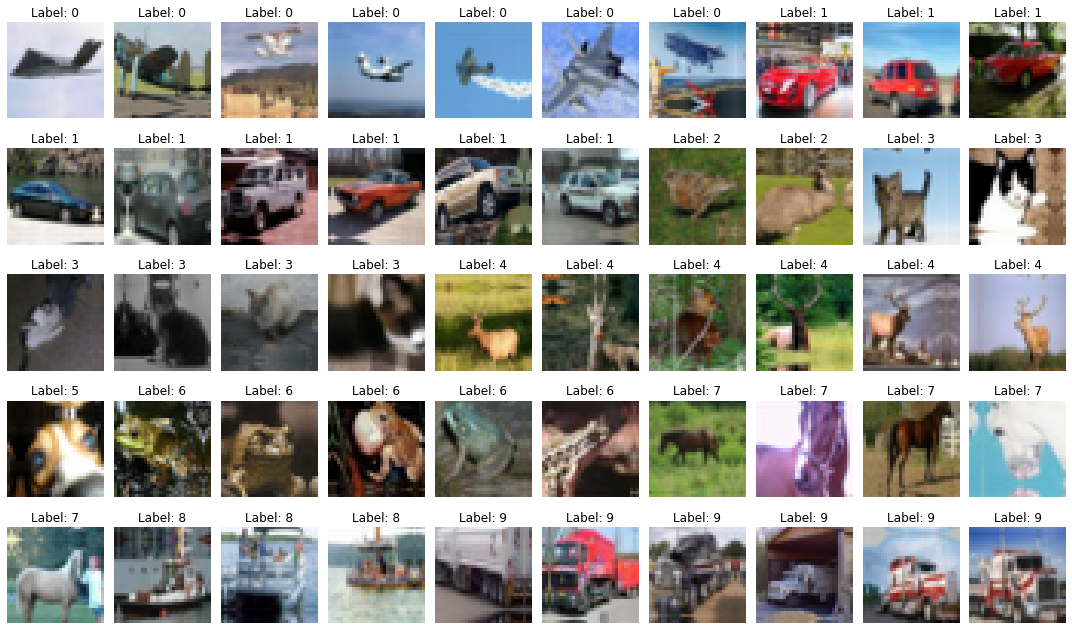

In [20]:
# def unnormalize(img, stats):
#     mean = np.array(stats[0])
#     std = np.array(stats[1])
#     img = img * std[:, None, None] + mean[:, None, None]
#     img = np.transpose(img, (1, 2, 0))
#     return img


# fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(15,9))

# sorted_subset = sorted(subset, key=lambda x: x[1])

# for i, (img, label) in enumerate(sorted_subset):
#     img = unnormalize(img, stats)
#     row = i // 10
#     col = i % 10
#     axes[row][col].imshow(img)
#     axes[row][col].axis('off')
#     axes[row][col].set_title(f"Label: {label}")

# plt.tight_layout()
# plt.show()

#### Training and eval functions

In [7]:
from IPython.display import display, clear_output
import datetime
from tqdm.notebook import tqdm

def train_model(model, trainloader, criterion, optimizer, device, i, epoch, num_epochs, train_acc:list, train_losses:list):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}, Run {i+1} - Training", leave=True)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
            
        optimizer.zero_grad()
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
            
        pbar.set_postfix({'Loss': train_loss / (pbar.n + 1e-8)})


    pbar.close()
    train_accuracy = 100.0 * correct / total
    train_acc.append(train_accuracy)
    return train_loss , train_accuracy, train_acc, train_losses

def update_subset(trainset, indices, samples_per_cluster, n_clusters, kmeans, cluster_samples):
    new_indices = []
    for i in range(n_clusters):
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        start = int(cluster_samples[i])
        end = int(min(start + samples_per_cluster, len(cluster_indices)))
        selected_indices = cluster_indices[start:end]
        new_indices.extend(selected_indices)
        cluster_samples[i] = end
    
    indices.extend(new_indices)
    subset = Subset(trainset, indices)
    trainloader = DataLoader(subset, batch_size=400, shuffle=True)
    return trainloader, indices, cluster_samples

def evaluate_model(model, valloader, criterion, device, epoch, num_epochs, test_acc:list, test_losses:list):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(valloader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=True)
        for inputs, labels in pbar:

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_losses.append(loss)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        pbar.close()
    accuracy = 100.0 * correct / total
    test_acc.append(accuracy)
    return val_loss, accuracy, test_acc, test_losses

#### Training, estimated time: 10 min

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Validation Set
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=valid_tfms)
valloader = torch.utils.data.DataLoader(valset, batch_size=400, shuffle=False)


# Model
model = resnet18(pretrained=False).to(device)
num_classes = 10
model.fc = nn.Linear(512, num_classes)
model = model.to(device)

# Parameters
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
max_samples = len(trainset)
current_samples = len(subset)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
cluster_samples = [samples_per_cluster for _ in range(n_clusters)]

train_acc_list = []
test_acc_list = []
train_losses = []
test_losses_list = []
trainloader = DataLoader(subset, batch_size=400, shuffle=True)

for epoch in range(num_epochs):

    print(f'Current sample size:{current_samples}')

    # Inner iteration
    for i in range(5):
        train_loss, train_accuracy, train_acc_list, train_losses = train_model(model, trainloader, criterion, optimizer, device, i, epoch, num_epochs, train_acc_list, train_losses)

    scheduler.step(train_losses[-1])

    # Validation
    val_loss, val_accuracy, test_acc_list, test_losses_list = evaluate_model(model, valloader, criterion, device, epoch, num_epochs, test_acc_list, test_losses_list)

    # Print stats
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss / len(trainloader):.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss / len(valloader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}% \n")

    # Increasing the size of previously selected best representing subset with randomly added data from dataset
    if current_samples < max_samples:
        samples_per_cluster *= 2
        trainloader, indices, cluster_samples = update_subset(trainset, indices, samples_per_cluster, n_clusters, kmeans, cluster_samples)
        subset = Subset(trainset, indices)
        current_samples = len(subset)


Epoch 5/10, Run 2 - Training:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5/10, Run 3 - Training:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5/10, Run 4 - Training:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5/10, Run 5 - Training:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5/10 - Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/10
Training Loss: 0.9755
Training Accuracy: 65.34%
Validation Loss: 1.1136
Validation Accuracy: 60.40% 

Current sample size:25200


Epoch 6/10, Run 1 - Training:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10, Run 2 - Training:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10, Run 3 - Training:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10, Run 4 - Training:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10, Run 5 - Training:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10 - Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/10
Training Loss: 0.8200
Training Accuracy: 70.85%
Validation Loss: 0.8839
Validation Accuracy: 69.63% 

Current sample size:44179


Epoch 7/10, Run 1 - Training:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 7/10, Run 2 - Training:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 7/10, Run 3 - Training:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 7/10, Run 4 - Training:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 7/10, Run 5 - Training:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 7/10 - Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/10
Training Loss: 0.6712
Training Accuracy: 76.26%
Validation Loss: 0.7272
Validation Accuracy: 75.01% 

Current sample size:50000


Epoch 8/10, Run 1 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/10, Run 2 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/10, Run 3 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/10, Run 4 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/10, Run 5 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/10 - Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/10
Training Loss: 0.5468
Training Accuracy: 80.85%
Validation Loss: 0.6268
Validation Accuracy: 78.35% 

Current sample size:50000


Epoch 9/10, Run 1 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9/10, Run 2 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9/10, Run 3 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9/10, Run 4 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9/10, Run 5 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9/10 - Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/10
Training Loss: 0.4673
Training Accuracy: 83.68%
Validation Loss: 0.6434
Validation Accuracy: 78.82% 

Current sample size:50000


Epoch 10/10, Run 1 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10/10, Run 2 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10/10, Run 3 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10/10, Run 4 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10/10, Run 5 - Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10/10 - Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/10
Training Loss: 0.3936
Training Accuracy: 86.07%
Validation Loss: 0.5778
Validation Accuracy: 80.76% 



In [9]:
import pickle

with open("subset/test_acc", "wb") as fp:
    pickle.dump(test_acc_list, fp)

with open("subset/test_loss", "wb") as fp:
    pickle.dump(test_losses_list, fp)

with open("subset/train_acc", "wb") as fp:
    pickle.dump(train_acc_list, fp)

with open("subset/train_loss", "wb") as fp:
    pickle.dump(train_losses, fp)

#### Whole dataset, estimated time: 17 min

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# transformer structrues
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)
])

transform_val = transforms.Compose([transforms.Resize((32, 32)),transforms.ToTensor(), transforms.Normalize(*stats)])

# Loading CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

# Dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True,  num_workers=2, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=False,  num_workers=2, pin_memory=True)

# Model Initialization
model = torchvision.models.resnet18(pretrained=False, num_classes=10)
model.fc = nn.Linear(512, 10) 
model = model.to(device)

# Parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
num_epochs = 10

train_acc_list = []
test_acc_list = []
train_losses = []
test_losses_list = []

for epoch in range(num_epochs):
    # Iterations
    for i in range(5):
        train_loss, train_accuracy, train_acc_list, train_losses = train_model(model, trainloader, criterion, optimizer, device, i, epoch, num_epochs, train_acc_list, train_losses)

    scheduler.step(train_losses[-1])

    # Validation
    val_loss, val_accuracy, test_acc_list, test_losses_list = evaluate_model(model, valloader, criterion, device, epoch, num_epochs, test_acc_list, test_losses_list)

    # Printing
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss / len(trainloader):.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss / len(valloader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")



Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, Run 1 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/10, Run 2 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/10, Run 3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/10, Run 4 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/10, Run 5 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/10 - Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10
Training Loss: 0.9498
Training Accuracy: 66.49%
Validation Loss: 0.8548
Validation Accuracy: 70.53%


Epoch 2/10, Run 1 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/10, Run 2 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/10, Run 3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/10, Run 4 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/10, Run 5 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/10 - Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2/10
Training Loss: 0.6873
Training Accuracy: 76.15%
Validation Loss: 0.6783
Validation Accuracy: 76.97%


Epoch 3/10, Run 1 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/10, Run 2 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/10, Run 3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/10, Run 4 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/10, Run 5 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/10 - Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3/10
Training Loss: 0.5759
Training Accuracy: 79.93%
Validation Loss: 0.5966
Validation Accuracy: 79.52%


Epoch 4/10, Run 1 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/10, Run 2 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/10, Run 3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/10, Run 4 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/10, Run 5 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/10 - Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4/10
Training Loss: 0.4954
Training Accuracy: 82.84%
Validation Loss: 0.5464
Validation Accuracy: 81.69%


Epoch 5/10, Run 1 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/10, Run 2 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/10, Run 3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/10, Run 4 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/10, Run 5 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/10 - Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5/10
Training Loss: 0.4242
Training Accuracy: 85.37%
Validation Loss: 0.5620
Validation Accuracy: 81.04%


Epoch 6/10, Run 1 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/10, Run 2 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/10, Run 3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/10, Run 4 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/10, Run 5 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/10 - Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6/10
Training Loss: 0.3862
Training Accuracy: 86.48%
Validation Loss: 0.5220
Validation Accuracy: 82.89%


Epoch 7/10, Run 1 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/10, Run 2 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/10, Run 3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/10, Run 4 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/10, Run 5 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/10 - Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7/10
Training Loss: 0.3496
Training Accuracy: 87.98%
Validation Loss: 0.5049
Validation Accuracy: 83.60%


Epoch 8/10, Run 1 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/10, Run 2 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/10, Run 3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/10, Run 4 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/10, Run 5 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/10 - Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8/10
Training Loss: 0.3090
Training Accuracy: 89.26%
Validation Loss: 0.5224
Validation Accuracy: 83.52%


Epoch 9/10, Run 1 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/10, Run 2 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/10, Run 3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/10, Run 4 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/10, Run 5 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/10 - Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9/10
Training Loss: 0.2947
Training Accuracy: 89.68%
Validation Loss: 0.5375
Validation Accuracy: 83.35%


Epoch 10/10, Run 1 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/10, Run 2 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/10, Run 3 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/10, Run 4 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/10, Run 5 - Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/10 - Validation:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10/10
Training Loss: 0.2564
Training Accuracy: 90.87%
Validation Loss: 0.5230
Validation Accuracy: 84.43%


In [11]:
import pickle

with open("whole-dataset/test_acc", "wb") as fp:
    pickle.dump(test_acc_list, fp)

with open("whole-dataset/test_loss", "wb") as fp:
    pickle.dump(test_losses_list, fp)

with open("whole-dataset/train_acc", "wb") as fp:
    pickle.dump(train_acc_list, fp)

with open("whole-dataset/train_loss", "wb") as fp:
    pickle.dump(train_losses, fp)

### Plots

#### 50k

In [12]:
import pickle

with open("whole-dataset/test_acc", "rb") as fp:
    whole_test_acc = pickle.load(fp)

with open("whole-dataset/train_acc", "rb") as fp:
    whole_train_acc = pickle.load(fp)

with open("whole-dataset/test_loss", "rb") as fp:
    whole_test_loss = pickle.load(fp)

with open("whole-dataset/train_loss", "rb") as fp:
    whole_train_loss = pickle.load(fp)


In [13]:
import pickle

with open("subset/test_acc", "rb") as fp:
    sub_test_acc = pickle.load(fp)

with open("subset/test_loss", "rb") as fp:
    sub_test_loss = pickle.load(fp)

with open("subset/train_acc", "rb") as fp:
    sub_train_acc = pickle.load(fp)

with open("subset/train_loss", "rb") as fp:
    sub_rain_loss = pickle.load(fp)

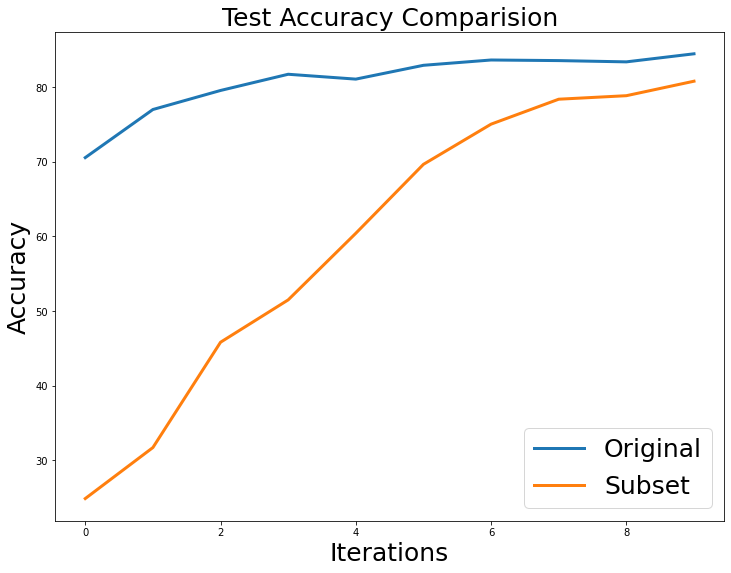

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
plt.plot(whole_test_acc, linewidth=3, label="Original")
plt.plot(sub_test_acc, linewidth=3, label="Subset")
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.title('Test Accuracy Comparision', fontsize=25)
plt.legend(loc='lower right', fontsize='25')
plt.show()

In [15]:
sub_test_acc

[24.88, 31.71, 45.81, 51.48, 60.4, 69.63, 75.01, 78.35, 78.82, 80.76]

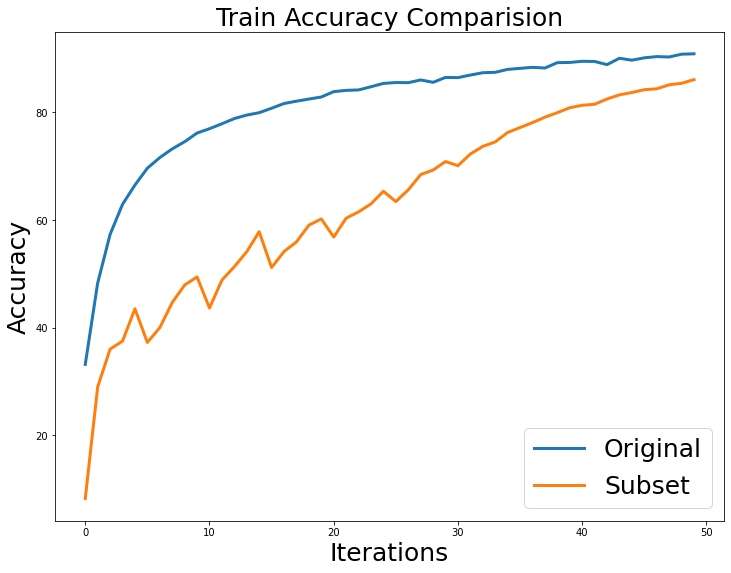

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
plt.plot(whole_train_acc, linewidth=3, label="Original")
plt.plot(sub_train_acc, linewidth=3, label="Subset")
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('Accuracy', fontsize='25')
plt.legend(loc='lower right', fontsize=25)
plt.title('Train Accuracy Comparision', fontsize=25)
plt.show()

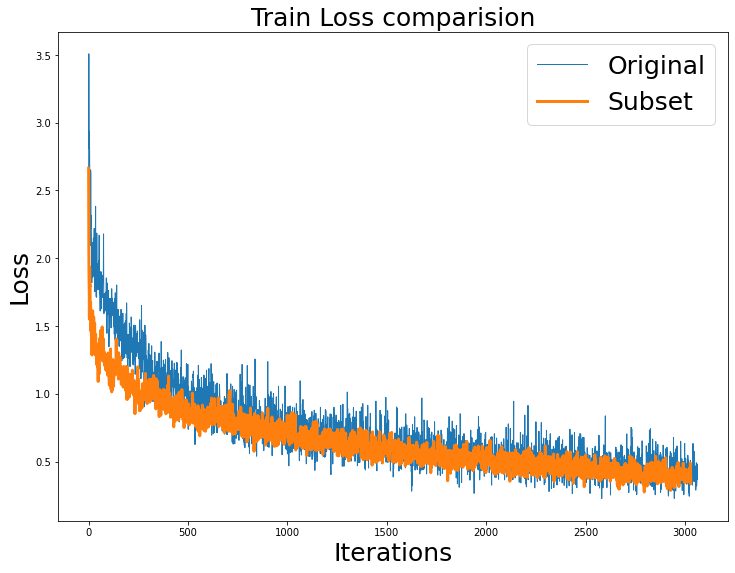

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
plt.plot([tensor.item() for tensor in whole_train_loss][0:12250:4], linewidth=1, label="Original")
plt.plot([tensor.item() for tensor in sub_rain_loss], linewidth=3, label="Subset")

plt.xlabel('Iterations', fontsize=25)
plt.ylabel('Loss', fontsize=25)
plt.legend(fontsize=25)
plt.title('Train Loss comparision', fontsize=25)
plt.show()

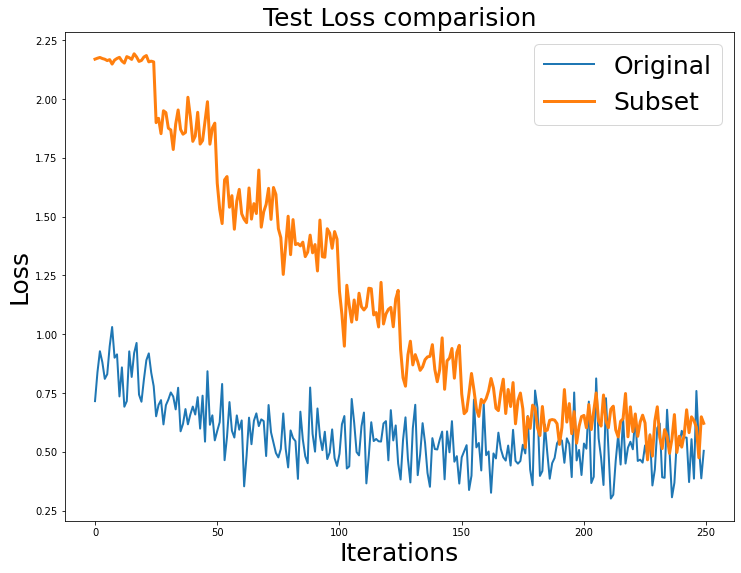

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
plt.plot([tensor.item() for tensor in whole_test_loss][0:1000:4], linewidth=2, label="Original")
plt.plot([tensor.item() for tensor in sub_test_loss], linewidth=3, label="Subset")
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('Loss', fontsize=25)
plt.legend(fontsize=25)
plt.title('Test Loss comparision', fontsize=25)
plt.show()